# 1. Data preprocessing

In [1]:
# %pip install matplotlib scikit-learn pandas

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import re

In [3]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

# Define Domains
df1['domain'], df2['domain'] = 1, 2

# Split set 1
x1_tr, x_dv = train_test_split(df1, stratify=df1['label'], random_state=0, test_size=0.2)
# Split set 2
x2_1 = df2[df2['label'] == 1].sample(500, random_state=0)
x2_0 = df2[df2['label'] == 0].sample(500, random_state=0)
x2_tr = df2[[i not in list(pd.concat([x2_1, x2_0]).reset_index()['index']) for i in df2.index]].reset_index(drop=True)
x2_dev = pd.concat([x2_1,x2_0]).reset_index(drop=True)

# Train test sets
df_train = pd.concat([x1_tr, x2_tr]).sample(frac=1).reset_index(drop=True)
df_dev = pd.concat([x_dv, x2_dev]).sample(frac=1).reset_index(drop=True)

# Print classes proportion
print(round(df_train['label'].value_counts()/len(df_train['label']),2))

label
0    0.81
1    0.19
Name: count, dtype: float64


# 3 DL Models (BiLSTM)

In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [5]:
# Weights function
def weights(df):
    w = list(len(df['label'])/df['label'].value_counts())
    sample_weights = [0] * df.shape[0]
    for idx, label in enumerate(df['label']):
        sample_weights[idx] = w[label]
    return sample_weights

# Prepare pytorch dataset
class Dataset(Dataset):
    def __init__(self, text, labels):
        self.text = text
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        text = torch.tensor(self.text[idx])
        label = torch.tensor(self.labels[idx])
        return text, label
    
# Define collate (pre_process) function
def collate_batch(batch):  
    texts, labels = zip(*batch)
    text_len = [len(txt) for txt in texts]
    text = nn.utils.rnn.pad_sequence(texts, batch_first=True).to(device)
    labels = torch.tensor(labels, dtype=torch.float32).to(device).reshape(-1,1)
    return text, labels, text_len

# Create datasets
train_DS = Dataset(df_train['text'], df_train['label'])
dev_DS = Dataset(df_dev['text'], df_dev['label'])

# Sample train data
sampler_tr = torch.utils.data.WeightedRandomSampler(weights(df_train), num_samples=len(train_DS), replacement=True)

bs =32
x_tr_dl = DataLoader(train_DS, batch_size=bs, collate_fn=collate_batch, sampler=sampler_tr)
x_dev_dl = DataLoader(dev_DS, batch_size=bs, collate_fn=collate_batch)

In [6]:
# Bidirectional LSTM model
class BiLSTM(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers):
        super(BiLSTM, self).__init__()
        # Embeding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=n_layers, batch_first=True,dropout = 0.5)
        # Linear layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        # Sigmoid layer
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        # Embeding 
        embedded = self.dropout(self.embedding(text))
        # Batch packing
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)
        # BiLSTM pass
        output, (hidden, cell_state) = self.lstm(packed_embedded)
        # Concatenate hidden states in the BiLSTM
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        # Linear layer
        linear = self.fc(hidden)
        # Return the classifier's output
        return self.Sigmoid(linear)

In [7]:
# Instantiate the model
model = BiLSTM(vocab_size=90000, embedding_dim=128*2, hidden_dim=256*2, output_dim=1, n_layers=2).to(device)
print(model)

BiLSTM(
  (embedding): Embedding(90000, 256, padding_idx=0)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (Sigmoid): Sigmoid()
)


In [8]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters())

# Loss fn
# loss_fn = nn.BCEWithLogitsLoss()
# Weights function
def weights_class(y):
    y = pd.Series(y.int().numpy(force=True).reshape(-1))
    w = len(y)/y.value_counts()
    try:
        return w[1]
        
    except:
        return 0

In [9]:
from tqdm import tqdm
from sklearn.metrics import f1_score
# Train
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, total, acc, real, preds = 0, 0, 0, [], []
    for X, y, text_len in tqdm(dataloader):
        pred = model(X, text_len)               # Forward pass
        loss_fn = nn.BCELoss(weight = torch.tensor(weights_class(y)).to(device))
        loss = loss_fn(pred, y)                 # Compute loss 
        loss.backward()                         # Backpropagation
        optimizer.step()                        # Update parameters
        optimizer.zero_grad()                   # Reset gradient
    
        # Metrics
        acc += torch.sum((pred>=0.5).float() == y)
        real.extend((y>=0.5).int().detach().cpu().numpy().reshape(-1,1))
        preds.extend((pred>=0.5).int().detach().cpu().numpy().reshape(-1,1))
        train_loss += loss.item()
        total += len(y)
    # General metrics
    train_loss /= total
    return train_loss, acc/size, f1_score(real, preds)

In [10]:
# Test
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, total, acc, real, preds = 0, 0, 0, [], []
    with torch.no_grad():       # Specify no gradient
        for X, y, text_len in tqdm(dataloader):
            pred = model(X, text_len)               # Forward pass   
            loss_fn = nn.BCELoss()
            
            # Metrics
            acc += torch.sum((pred>=0.5).float() == y)
            real.extend((y>=0.5).int().detach().cpu().numpy().reshape(-1,1))
            preds.extend((pred>=0.5).int().detach().cpu().numpy().reshape(-1,1))
            
            test_loss += loss_fn(pred, y).item()    # Compute loss  
            total += len(y)                         # Total observations

    # General metrics
    test_loss /= total
    return test_loss, acc/size, f1_score(real, preds)

In [11]:
from tqdm import tqdm, tqdm_notebook # show progress bar

# Epochs
epochs = 25
train_loss, valid_loss = [], []
print("Training BiLSTM network model!")
for t in range(epochs):
    tl, train_acc, f1_tr = train(x_tr_dl, model, optimizer)
    vl, valid_acc, f1_ts = test(x_dev_dl, model)
    # Losses to dict
    train_loss.append(tl)
    valid_loss.append(vl)

    # Print results
    tqdm.write(
        f'epoch #{t}\ttrain_acc: {train_acc:.3f}\tvalid_acc: {valid_acc:.3f}',
    )
    tqdm.write(
        f'epoch #{t}\tf1_tr: {f1_tr:.3f}\tf1_ts: {f1_ts:.3f}',
    )

Training BiLSTM network model!


100%|██████████| 63/63 [00:02<00:00, 21.57it/s]


epoch #0	train_acc: 0.739	valid_acc: 0.581
epoch #0	f1_tr: 0.732	f1_ts: 0.530


100%|██████████| 63/63 [00:02<00:00, 21.55it/s]


epoch #1	train_acc: 0.812	valid_acc: 0.645
epoch #1	f1_tr: 0.811	f1_ts: 0.646


100%|██████████| 63/63 [00:02<00:00, 22.34it/s]


epoch #2	train_acc: 0.874	valid_acc: 0.666
epoch #2	f1_tr: 0.876	f1_ts: 0.637


100%|██████████| 63/63 [00:02<00:00, 21.51it/s]


epoch #3	train_acc: 0.914	valid_acc: 0.709
epoch #3	f1_tr: 0.914	f1_ts: 0.702


100%|██████████| 63/63 [00:02<00:00, 21.64it/s]


epoch #4	train_acc: 0.936	valid_acc: 0.711
epoch #4	f1_tr: 0.937	f1_ts: 0.672


100%|██████████| 63/63 [00:02<00:00, 21.82it/s]


epoch #5	train_acc: 0.953	valid_acc: 0.729
epoch #5	f1_tr: 0.953	f1_ts: 0.695


100%|██████████| 63/63 [00:02<00:00, 22.85it/s]


epoch #6	train_acc: 0.961	valid_acc: 0.743
epoch #6	f1_tr: 0.961	f1_ts: 0.708


100%|██████████| 63/63 [00:02<00:00, 21.78it/s]


epoch #7	train_acc: 0.967	valid_acc: 0.743
epoch #7	f1_tr: 0.967	f1_ts: 0.695


100%|██████████| 63/63 [00:02<00:00, 23.44it/s]


epoch #8	train_acc: 0.975	valid_acc: 0.721
epoch #8	f1_tr: 0.975	f1_ts: 0.661


100%|██████████| 63/63 [00:02<00:00, 22.04it/s]


epoch #9	train_acc: 0.977	valid_acc: 0.736
epoch #9	f1_tr: 0.977	f1_ts: 0.683


100%|██████████| 63/63 [00:02<00:00, 23.21it/s]


epoch #10	train_acc: 0.977	valid_acc: 0.731
epoch #10	f1_tr: 0.977	f1_ts: 0.672


100%|██████████| 63/63 [00:02<00:00, 22.96it/s]


epoch #11	train_acc: 0.981	valid_acc: 0.773
epoch #11	f1_tr: 0.981	f1_ts: 0.739


100%|██████████| 63/63 [00:02<00:00, 22.18it/s]


epoch #12	train_acc: 0.984	valid_acc: 0.762
epoch #12	f1_tr: 0.984	f1_ts: 0.716


100%|██████████| 63/63 [00:02<00:00, 21.96it/s]


epoch #13	train_acc: 0.985	valid_acc: 0.782
epoch #13	f1_tr: 0.985	f1_ts: 0.750


100%|██████████| 63/63 [00:02<00:00, 22.96it/s]


epoch #14	train_acc: 0.987	valid_acc: 0.749
epoch #14	f1_tr: 0.987	f1_ts: 0.698


100%|██████████| 63/63 [00:02<00:00, 23.69it/s]


epoch #15	train_acc: 0.989	valid_acc: 0.707
epoch #15	f1_tr: 0.989	f1_ts: 0.622


100%|██████████| 63/63 [00:02<00:00, 23.54it/s]


epoch #16	train_acc: 0.986	valid_acc: 0.760
epoch #16	f1_tr: 0.986	f1_ts: 0.715


100%|██████████| 63/63 [00:02<00:00, 22.86it/s]


epoch #17	train_acc: 0.989	valid_acc: 0.745
epoch #17	f1_tr: 0.989	f1_ts: 0.690


100%|██████████| 63/63 [00:02<00:00, 22.53it/s]


epoch #18	train_acc: 0.987	valid_acc: 0.737
epoch #18	f1_tr: 0.988	f1_ts: 0.675


100%|██████████| 63/63 [00:02<00:00, 22.13it/s]


epoch #19	train_acc: 0.989	valid_acc: 0.764
epoch #19	f1_tr: 0.989	f1_ts: 0.725


100%|██████████| 63/63 [00:02<00:00, 21.77it/s]


epoch #20	train_acc: 0.991	valid_acc: 0.749
epoch #20	f1_tr: 0.991	f1_ts: 0.690


100%|██████████| 63/63 [00:02<00:00, 22.14it/s]


epoch #21	train_acc: 0.991	valid_acc: 0.710
epoch #21	f1_tr: 0.991	f1_ts: 0.619


100%|██████████| 63/63 [00:02<00:00, 22.97it/s]


epoch #22	train_acc: 0.993	valid_acc: 0.765
epoch #22	f1_tr: 0.992	f1_ts: 0.721


100%|██████████| 63/63 [00:02<00:00, 22.62it/s]


epoch #23	train_acc: 0.994	valid_acc: 0.703
epoch #23	f1_tr: 0.994	f1_ts: 0.601


100%|██████████| 63/63 [00:02<00:00, 24.03it/s]

epoch #24	train_acc: 0.993	valid_acc: 0.757
epoch #24	f1_tr: 0.993	f1_ts: 0.703


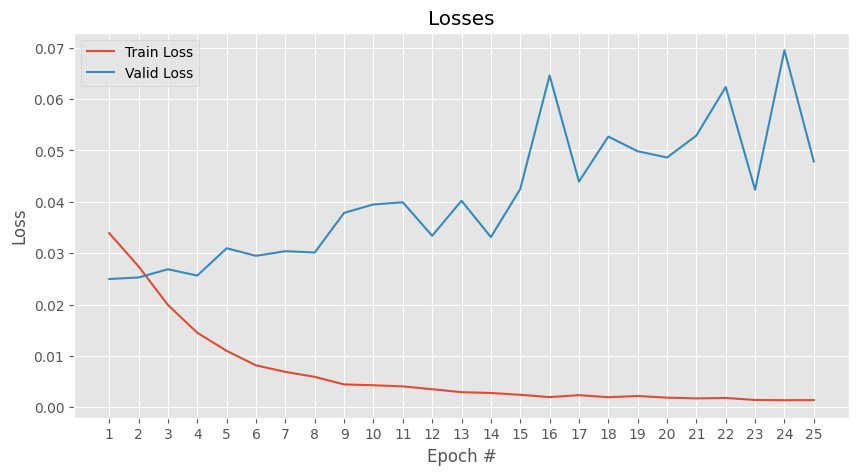

In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
epoch_ticks = range(1, t+1 + 1)
plt.plot(epoch_ticks, train_loss)
plt.plot(epoch_ticks, valid_loss)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [13]:
def predict(dl, ln):
    with torch.no_grad():  # Disable gradient computation for efficiency
        preds, acc, test_acc = [], 0, 0
        for X, y, text_len in dl:
            # Dev data
            pred = model(X, text_len)
            test_acc += torch.sum((pred>=0.5).float() == y)
    return (test_acc/ln).detach().cpu().numpy().item()

In [14]:
predict(x_tr_dl, df_train.shape[0])

0.9985000491142273

In [15]:
predict(x_dev_dl, df_dev.shape[0])

0.7565000653266907

# Predict on sample data

In [16]:
test = pd.read_json('../Data/test_data.json', lines=True)['text']
# train = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df_train['text']]
test = [[t if t != 0 else 1 for t in ls] for ls in test]

In [17]:
preds = []
for line in test:
    text_tensor = torch.tensor(line).unsqueeze(0).to(device)
    text_length = torch.tensor([len(line)])
    # Pass the sequence and its length to the model
    prediction = model(text_tensor, text_length)
    preds.extend((prediction>=0.5).int().detach().cpu().numpy().reshape(-1))

In [18]:
test_df = pd.DataFrame(columns = ['id', 'value'])
for idx, v in enumerate(preds):
    test_df.loc[idx] = [idx, preds[idx]]
test_df.to_csv('predictions.csv', index=False)

In [19]:
test_df['value'].value_counts()

value
0    2661
1    1339
Name: count, dtype: int64

In [20]:
#  Export model
model_scripted = torch.jit.script(model.to('cpu') # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

SyntaxError: '(' was never closed (664557103.py, line 2)

In [ ]:
# Load Model
model = torch.jit.load('model_scripted.pt')
model.eval()